<a href="https://colab.research.google.com/github/KANG-HYUNIL/AudioTrain/blob/main/BSS_STUUDY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# BSS 내용 배우는 도중, ICA 관련 내용 실습해보기
# 데이터 준비
# Centering
# Whitening
# PCA
# FastICA 등등...

!pip -q install numpy scipy scikit-learn librosa soundfile

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from scipy.io import wavfile

# sklearn: PCA / FastICA
from sklearn.decomposition import PCA, FastICA

# 재현성
rng = np.random.default_rng(42)

# 그래프 옵션(취향)
plt.rcParams["figure.figsize"] = (10, 3)




In [3]:
# 데이터 준비
import librosa, soundfile as sf


sr = 16000
dur = 6.0
n = int(sr * dur)
t = np.linspace(0, dur, n, endpoint=False)

# Librosa 예제 파일 경로(버전에 따라 librosa.ex 혹은 librosa.example로 접근)
# 문서: https://librosa.org/doc/latest/recordings.html
trumpet_path = librosa.ex('trumpet')   # 악기
libri_path   = librosa.ex('libri1')    # 음성
y1, _ = librosa.load(trumpet_path, sr=sr, mono=True)  # sr 고정 로드  :contentReference[oaicite:4]{index=4}
y2, _ = librosa.load(libri_path,   sr=sr, mono=True)

# 길이 맞추기 (둘 중 짧은 길이에 맞춤)
L = min(len(y1), len(y2), n)
s1 = y1[:L]
s2 = y2[:L]
s1 = s1 / (np.std(s1) + 1e-12)
s2 = s2 / (np.std(s2) + 1e-12)
S  = np.stack([s1, s2], axis=1)

print("Sources shape:", S.shape, "duration_sec:", S.shape[0]/sr)
display(Audio(s1, rate=sr))
display(Audio(s2, rate=sr))



Sources shape: (85335, 2) duration_sec: 5.3334375


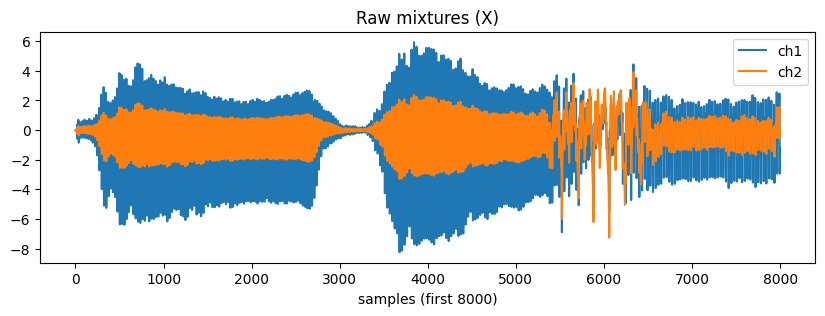

In [4]:
# 혼합 신호 및 관측된 신호 시각화해보기
# 풀랭크 혼합행렬 A
A = np.array([[1.0, 0.6],
              [0.4, 1.0]])

X = S @ A.T   # (n, 2)
X += 0.005 * rng.standard_normal(size=X.shape)  # 소량 노이즈

def plot_two(arr, title):
    plt.figure()
    plt.plot(arr[:8000,0], label='ch1')
    plt.plot(arr[:8000,1], label='ch2')
    plt.title(title)
    plt.xlabel("samples (first 8000)")
    plt.legend()
    plt.show()

plot_two(X, "Raw mixtures (X)")
display(Audio(X[:,0], rate=sr))
display(Audio(X[:,1], rate=sr))

### BSS(Blind Source Separation) 및 ICA(Independent Component Analysis) 실습 준비

이 셀은 BSS 및 ICA 실습을 위한 환경 설정 및 라이브러리 임포트를 수행합니다. 필요한 라이브러리(`numpy`, `scipy`, `scikit-learn`, `librosa`, `soundfile`)를 설치하고, 데이터 로딩, 시각화, ICA 알고리즘 적용에 필요한 모듈을 임포트합니다. 또한, 결과의 재현성을 위한 랜덤 시드 설정과 그래프 출력을 위한 기본 설정을 포함합니다.

In [ ]:
# BSS 내용 배우는 도중, ICA 관련 내용 실습해보기
# 데이터 준비
# Centering
# Whitening
# PCA
# FastICA 등등...

!pip -q install numpy scipy scikit-learn librosa soundfile

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from scipy.io import wavfile

# sklearn: PCA / FastICA
from sklearn.decomposition import PCA, FastICA

# 재현성
rng = np.random.default_rng(42)

# 그래프 옵션(취향)
plt.rcParams["figure.figsize"] = (10, 3)

### 원본 음원 데이터 준비

이 셀은 ICA 실습에 사용할 원본 음원 데이터를 로드하고 전처리합니다. `librosa` 라이브러리를 사용하여 트럼펫 소리와 음성 파일 두 가지를 지정된 샘플링 레이트(`sr=16000`)로 로드합니다. 두 음원의 길이를 동일하게 맞추고, 각 음원의 표준 편차를 1로 맞춰 스케일을 정규화합니다. 준비된 원본 음원은 `S` 변수에 저장되며, 각 음원을 들어볼 수 있도록 출력합니다.

In [ ]:
# 데이터 준비
import librosa, soundfile as sf


sr = 16000
dur = 6.0
n = int(sr * dur)
t = np.linspace(0, dur, n, endpoint=False)

# Librosa 예제 파일 경로(버전에 따라 librosa.ex 혹은 librosa.example로 접근)
# 문서: https://librosa.org/doc/latest/recordings.html
trumpet_path = librosa.ex('trumpet')   # 악기
libri_path   = librosa.ex('libri1')    # 음성
y1, _ = librosa.load(trumpet_path, sr=sr, mono=True)  # sr 고정 로드
y2, _ = librosa.load(libri_path,   sr=sr, mono=True)

# 길이 맞추기 (둘 중 짧은 길이에 맞춤)
L = min(len(y1), len(y2), n)
s1 = y1[:L]
s2 = y2[:L]
s1 = s1 / (np.std(s1) + 1e-12)
s2 = s2 / (np.std(s2) + 1e-12)
S  = np.stack([s1, s2], axis=1)

print("Sources shape:", S.shape, "duration_sec:", S.shape[0]/sr)
display(Audio(s1, rate=sr))
display(Audio(s2, rate=sr))

### 혼합 신호 생성 및 시각화

이 셀은 준비된 원본 음원을 선형적으로 혼합하여 관측된 신호(`X`)를 생성합니다. 임의의 풀랭크 혼합 행렬 `A`를 사용하여 두 원본 신호를 혼합하고, 소량의 노이즈를 추가합니다. 생성된 혼합 신호의 처음 8000개 샘플을 시각화하여 두 채널의 파형을 확인하고, 각 혼합 신호를 오디오로 들어봅니다.

In [ ]:
# 혼합 신호 및 관측된 신호 시각화해보기
# 풀랭크 혼합행렬 A
A = np.array([[1.0, 0.6],
              [0.4, 1.0]])

X = S @ A.T   # (n, 2)
X += 0.005 * rng.standard_normal(size=X.shape)  # 소량 노이즈

def plot_two(arr, title):
    plt.figure()
    plt.plot(arr[:8000,0], label='ch1')
    plt.plot(arr[:8000,1], label='ch2')
    plt.title(title)
    plt.xlabel("samples (first 8000)")
    plt.legend()
    plt.show()

plot_two(X, "Raw mixtures (X)")
display(Audio(X[:,0], rate=sr))
display(Audio(X[:,1], rate=sr))

### Centering (평균 제거)

이 셀은 혼합 신호 `X`의 평균을 제거하는 centering 작업을 수행합니다. ICA의 전처리 단계 중 하나로, 데이터의 평균을 0으로 만들어 공분산 계산을 단순화합니다. centering된 신호 `Xc`의 공분산 및 상관 행렬을 계산하고 출력하여 평균 제거 후 데이터의 특성을 확인합니다. centering된 신호의 파형도 시각화하고 오디오로 들어봅니다.

In [ ]:
# Centering 해보기

Xc = X - X.mean(axis=0, keepdims=True)

def cov_corr(arr):
    C = np.cov(arr, rowvar=False)
    std = np.sqrt(np.diag(C) + 1e-12)
    R = C / (std[:,None]*std[None,:] + 1e-12)
    return C, R

C_xc, R_xc = cov_corr(Xc)
print("Centered mixtures Cov:\n", C_xc)
print("Centered mixtures Corr:\n", R_xc)
plot_two(Xc, "Centered mixtures (X - mean)")
display(Audio(Xc[:,0], rate=sr))
display(Audio(Xc[:,1], rate=sr))

### PCA (Principal Component Analysis) - Whitening 적용 안함

이 셀은 centering된 신호 `Xc`에 대해 PCA를 적용하지만, whitening은 수행하지 않습니다. PCA는 데이터의 차원을 축소하고 분산을 최대로 보존하는 주성분을 찾습니다. `whiten=False` 설정으로 비상관화만 수행된 결과 `Xp`의 공분산 및 상관 행렬을 출력하여, 성분들이 비상관화되었지만 분산이 1로 통일되지 않음을 확인합니다. 결과 파형도 시각화합니다.

In [ ]:
#PCA(whiten=False)pca_no_white = PCA(n_components=2, whiten=False, random_state=0)
pca_no_white = PCA(n_components=2, whiten=False, random_state=0)
Xp = pca_no_white.fit_transform(Xc)   # 비상관 성분
C_p, R_p = cov_corr(Xp)
print("PCA (no whitening) Cov:\n", C_p)   # 대각 분산 다름
print("PCA (no whitening) Corr:\n", R_p)  # 오프대각 ≈ 0

plot_two(Xp, "PCA scores (no whitening): uncorrelated but var != 1")

### Whitening (백색화)

이 셀은 centering된 신호 `Xc`에 대해 PCA를 사용하여 whitening을 수행합니다. Whitening은 데이터의 성분들을 비상관화시키고 각 성분의 분산을 1로 만들어 단위 공분산 행렬을 갖도록 변환합니다. `whiten=True` 설정으로 whitening된 결과 `Zw`의 공분산 및 상관 행렬을 출력하여, 공분산 행렬이 단위 행렬에 가까워졌음을 확인합니다. whitening된 신호의 파형도 시각화합니다.

In [ ]:
# Whitening


pca_white = PCA(n_components=2, whiten=True, random_state=0)
Zw = pca_white.fit_transform(Xc)    # 공분산 ≈ I
C_w, R_w = cov_corr(Zw)
print("Whitened Cov (≈ I):\n", C_w)
print("Whitened Corr (≈ 0 off-diag):\n", R_w)
plot_two(Zw, "Whitened (PCA-whitening): var≈1, corr≈0")

### FastICA를 이용한 원본 소스 분리

이 셀은 FastICA 알고리즘을 사용하여 혼합 신호로부터 원본 소스를 분리합니다. FastICA는 whitening된 데이터를 입력으로 받아 통계적 독립성을 최대화하는 방향으로 회전하여 원본 소스를 추정합니다. 추정된 소스 `Sh`는 원본 소스와 순서, 부호, 스케일의 모호성이 있을 수 있습니다.

원본 소스와 추정된 소스 간의 SI-SDR(Scale-Invariant Source-to-Distortion Ratio)을 계산하여 분리 성능을 평가하고, 최적의 순서로 추정된 소스를 정렬합니다. 정렬 전후의 추정된 소스 파형을 시각화하고, 최종 분리된 두 음원을 오디오로 들어봅니다. 마지막으로 원본, 혼합, 분리된 음원을 WAV 파일로 저장합니다.

In [ ]:
# FastICA - Independent 최대의 회전 탐색
ica = FastICA(n_components=2, random_state=0, max_iter=1000, tol=1e-4, whiten='unit-variance')
Sh = ica.fit_transform(Xc)   # 추정 소스 (순서/부호/스케일 모호성 존재)

# 퍼뮤테이션(순서) 정렬: 2개 소스라 브루트포스 비교
def si_sdr(reference, estimate, eps=1e-10):
    ref = reference - np.mean(reference)
    est = estimate - np.mean(estimate)
    alpha = np.dot(est, ref) / (np.dot(ref, ref) + eps)
    target = alpha * ref
    noise = est - target
    return 10 * np.log10((np.sum(target ** 2) + eps) / (np.sum(noise ** 2) + eps))

def best_perm(refs, ests):
    # refs, ests: shape (2, n)
    sdr_01 = si_sdr(refs[0], ests[0]) + si_sdr(refs[1], ests[1])
    sdr_10 = si_sdr(refs[0], ests[1]) + si_sdr(refs[1], ests[0])
    if sdr_10 > sdr_01:
        return np.stack([ests[1], ests[0]]), (si_sdr(refs[0], ests[1]), si_sdr(refs[1], ests[0]))
    else:
        return ests, (si_sdr(refs[0], ests[0]), si_sdr(refs[1], ests[1]))

Sh_t = Sh.T
S_t  = S.T
Sh_best, (sdr1, sdr2) = best_perm(S_t, Sh_t)
mean_sdr = (sdr1 + sdr2) / 2
print(f"SI-SDR after best permutation: s1={sdr1:.2f} dB, s2={sdr2:.2f} dB, mean={mean_sdr:.2f} dB")

plot_two(Sh, "FastICA outputs (before permutation align)")
plot_two(np.stack(Sh_best, axis=1), "FastICA outputs (aligned best permutation)")

# 들어보기/저장
sep1 = Sh_best[0] / (np.max(np.abs(Sh_best[0])) + 1e-12)
sep2 = Sh_best[1] / (np.max(np.abs(Sh_best[1])) + 1e-12)
display(Audio(sep1, rate=sr))
display(Audio(sep2, rate=sr))

wavfile.write('/content/ref_source1.wav', sr, (S_t[0] / (np.max(np.abs(S_t[0]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/ref_source2.wav', sr, (S_t[1] / (np.max(np.abs(S_t[1]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/mix1.wav', sr, (X[:,0] / (np.max(np.abs(X[:,0]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/mix2.wav', sr, (X[:,1] / (np.max(np.abs(X[:,1]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/separated1.wav', sr, (sep1 * 32767).astype(np.int16))
wavfile.write('/content/separated2.wav', sr, (sep2 * 32767).astype(np.int16))

print("Saved to /content/: ref_source1.wav, ref_source2.wav, mix1.wav, mix2.wav, separated1.wav, separated2.wav")

Centered mixtures Cov:
 [[1.36044227 1.00040957]
 [1.00040957 1.16030279]]
Centered mixtures Corr:
 [[1.         0.79625488]
 [0.79625488 1.        ]]


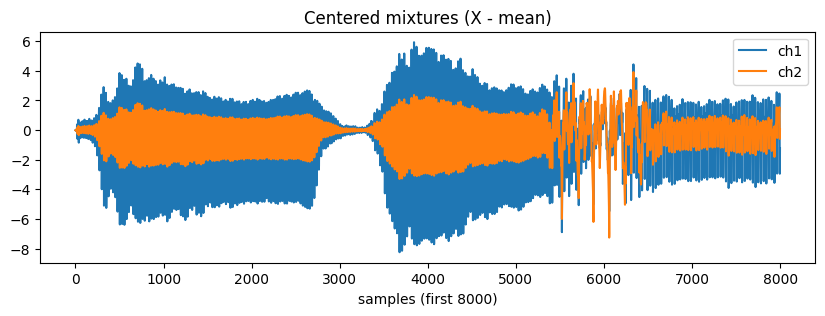

In [5]:
# Centering 해보기

Xc = X - X.mean(axis=0, keepdims=True)

def cov_corr(arr):
    C = np.cov(arr, rowvar=False)
    std = np.sqrt(np.diag(C) + 1e-12)
    R = C / (std[:,None]*std[None,:] + 1e-12)
    return C, R

C_xc, R_xc = cov_corr(Xc)
print("Centered mixtures Cov:\n", C_xc)
print("Centered mixtures Corr:\n", R_xc)
plot_two(Xc, "Centered mixtures (X - mean)")
display(Audio(Xc[:,0], rate=sr))
display(Audio(Xc[:,1], rate=sr))

PCA (no whitening) Cov:
 [[ 2.26577456e+00 -1.93177297e-16]
 [-1.93177297e-16  2.54970495e-01]]
PCA (no whitening) Corr:
 [[ 1.00000000e+00 -2.54157408e-16]
 [-2.54157408e-16  1.00000000e+00]]


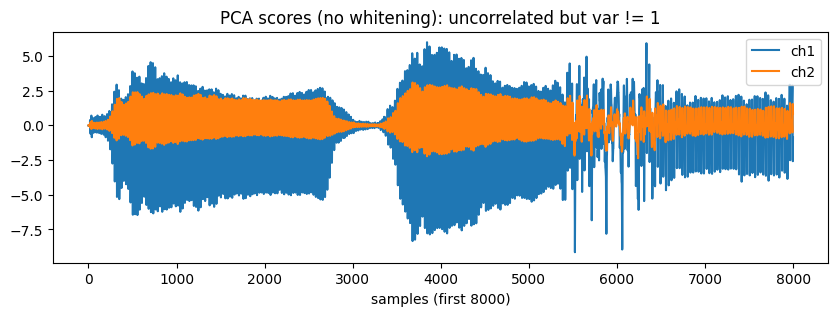

In [6]:
#PCA(whiten=False)pca_no_white = PCA(n_components=2, whiten=False, random_state=0)
pca_no_white = PCA(n_components=2, whiten=False, random_state=0)
Xp = pca_no_white.fit_transform(Xc)   # 비상관 성분
C_p, R_p = cov_corr(Xp)
print("PCA (no whitening) Cov:\n", C_p)   # 대각 분산 다름
print("PCA (no whitening) Corr:\n", R_p)  # 오프대각 ≈ 0

plot_two(Xp, "PCA scores (no whitening): uncorrelated but var != 1")

Whitened Cov (≈ I):
 [[ 1.00000000e+00 -1.72860374e-16]
 [-1.72860374e-16  1.00000000e+00]]
Whitened Corr (≈ 0 off-diag):
 [[ 1.00000000e+00 -1.72860374e-16]
 [-1.72860374e-16  1.00000000e+00]]


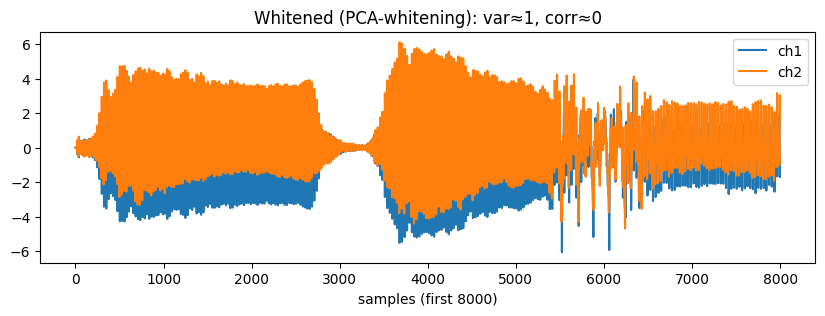

In [7]:
# Whitening


pca_white = PCA(n_components=2, whiten=True, random_state=0)
Zw = pca_white.fit_transform(Xc)    # 공분산 ≈ I
C_w, R_w = cov_corr(Zw)
print("Whitened Cov (≈ I):\n", C_w)
print("Whitened Corr (≈ 0 off-diag):\n", R_w)
plot_two(Zw, "Whitened (PCA-whitening): var≈1, corr≈0")

SI-SDR after best permutation: s1=42.22 dB, s2=42.91 dB, mean=42.57 dB


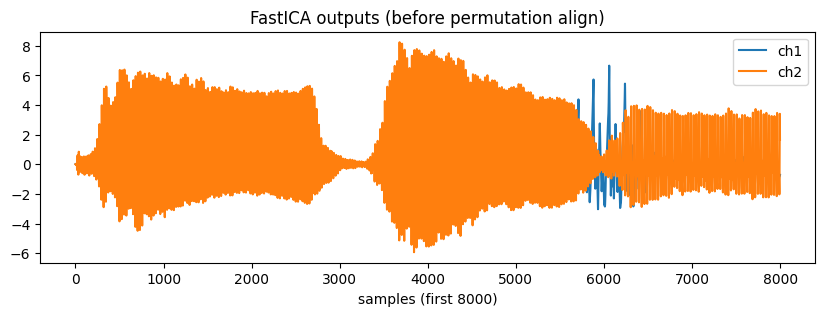

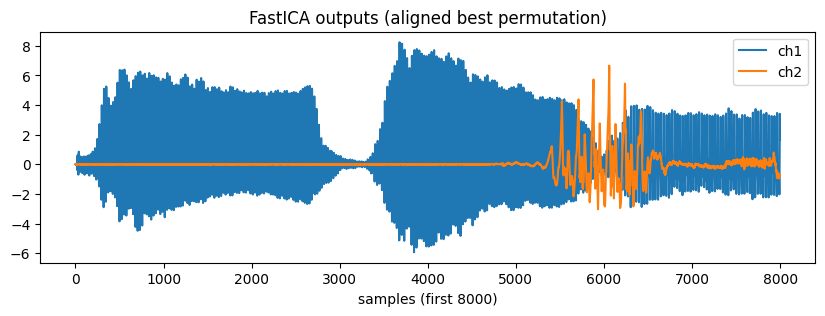

Saved to /content/: ref_source1.wav, ref_source2.wav, mix1.wav, mix2.wav, separated1.wav, separated2.wav


In [8]:
# FastICA - Independent 최대의 회전 탐색
ica = FastICA(n_components=2, random_state=0, max_iter=1000, tol=1e-4, whiten='unit-variance')
Sh = ica.fit_transform(Xc)   # 추정 소스 (순서/부호/스케일 모호성 존재)  :contentReference[oaicite:7]{index=7}

# 퍼뮤테이션(순서) 정렬: 2개 소스라 브루트포스 비교
def si_sdr(reference, estimate, eps=1e-10):
    ref = reference - np.mean(reference)
    est = estimate - np.mean(estimate)
    alpha = np.dot(est, ref) / (np.dot(ref, ref) + eps)
    target = alpha * ref
    noise = est - target
    return 10 * np.log10((np.sum(target ** 2) + eps) / (np.sum(noise ** 2) + eps))

def best_perm(refs, ests):
    # refs, ests: shape (2, n)
    sdr_01 = si_sdr(refs[0], ests[0]) + si_sdr(refs[1], ests[1])
    sdr_10 = si_sdr(refs[0], ests[1]) + si_sdr(refs[1], ests[0])
    if sdr_10 > sdr_01:
        return np.stack([ests[1], ests[0]]), (si_sdr(refs[0], ests[1]), si_sdr(refs[1], ests[0]))
    else:
        return ests, (si_sdr(refs[0], ests[0]), si_sdr(refs[1], ests[1]))

Sh_t = Sh.T
S_t  = S.T
Sh_best, (sdr1, sdr2) = best_perm(S_t, Sh_t)
mean_sdr = (sdr1 + sdr2) / 2
print(f"SI-SDR after best permutation: s1={sdr1:.2f} dB, s2={sdr2:.2f} dB, mean={mean_sdr:.2f} dB")

plot_two(Sh, "FastICA outputs (before permutation align)")
plot_two(np.stack(Sh_best, axis=1), "FastICA outputs (aligned best permutation)")

# 들어보기/저장
sep1 = Sh_best[0] / (np.max(np.abs(Sh_best[0])) + 1e-12)
sep2 = Sh_best[1] / (np.max(np.abs(Sh_best[1])) + 1e-12)
display(Audio(sep1, rate=sr))
display(Audio(sep2, rate=sr))

wavfile.write('/content/ref_source1.wav', sr, (S_t[0] / (np.max(np.abs(S_t[0]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/ref_source2.wav', sr, (S_t[1] / (np.max(np.abs(S_t[1]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/mix1.wav', sr, (X[:,0] / (np.max(np.abs(X[:,0]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/mix2.wav', sr, (X[:,1] / (np.max(np.abs(X[:,1]))+1e-12) * 32767).astype(np.int16))
wavfile.write('/content/separated1.wav', sr, (sep1 * 32767).astype(np.int16))
wavfile.write('/content/separated2.wav', sr, (sep2 * 32767).astype(np.int16))

print("Saved to /content/: ref_source1.wav, ref_source2.wav, mix1.wav, mix2.wav, separated1.wav, separated2.wav")